# Previsão de Séries Temporais

<div style="text-align:justify">
Uma série temporal é uma sequência de números coletados em intervalos regulares durante um período de tempo. Em modelos de regressão linear a ordem das observações é irrelevante para a análise, em séries temporais a ordem dos dados é fundamental. Uma característica muito importante deste tipo de dado é que as observações vizinhas são dependentes e o interesse é analisar e modelar essa dependência.
</div>

### Carregando Pacotes

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from pandas import Series
from pandas import concat
from pandas import DataFrame

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot, lag_plot

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

### Dataset

In [279]:
data = pd.read_csv('AirPassengers.csv', header=0, parse_dates=[0], names=['Month', 'Passengers'], index_col=0)

# read series.
ts = data['Passengers']
ts.head(5)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

### Visualização da Série

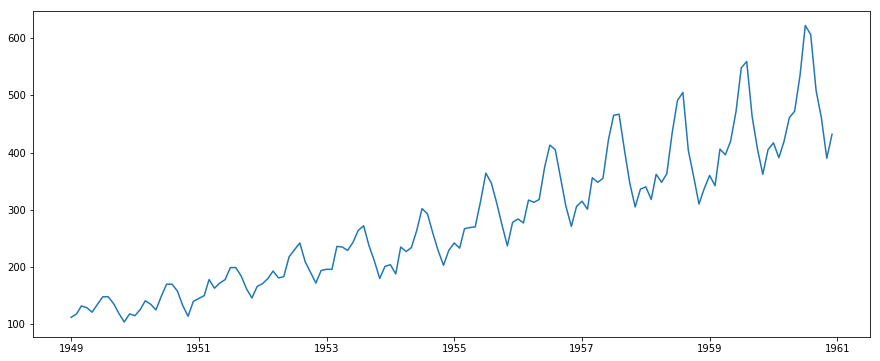

In [280]:
plt.plot(ts)
plt.show()

### Análise Gráfica de Auto-correlação

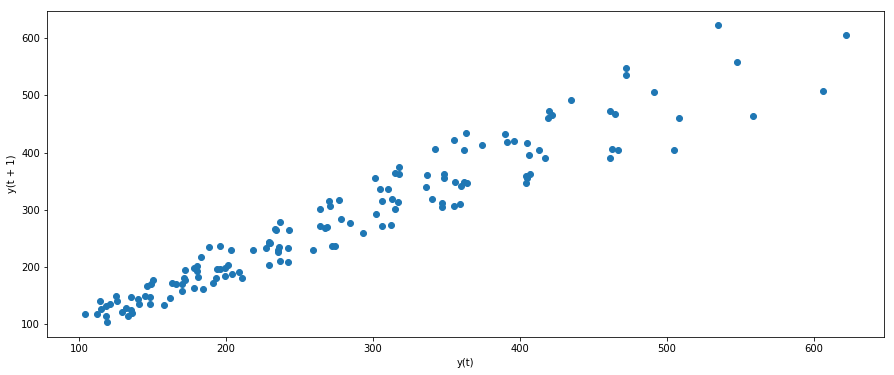

In [281]:
lag_plot(ts)

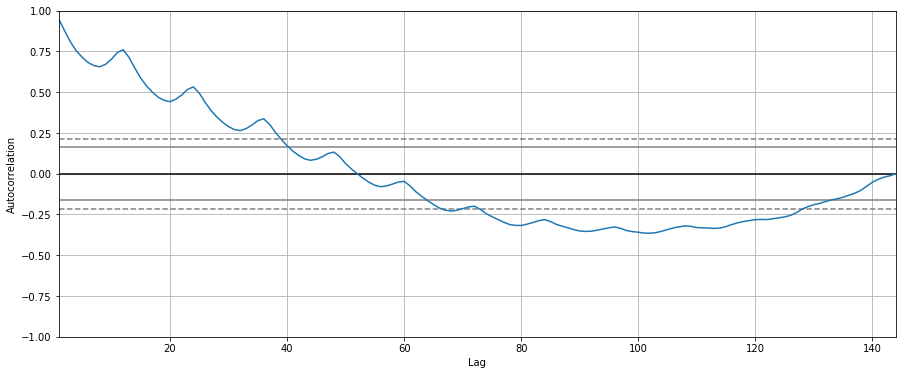

In [282]:
autocorrelation_plot(ts)

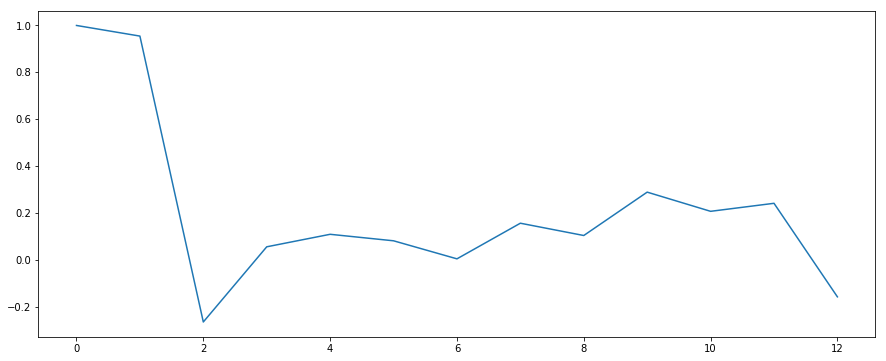

In [283]:
pacf_result = pacf(ts, nlags=12)
plt.plot(pacf_result)
plt.show()

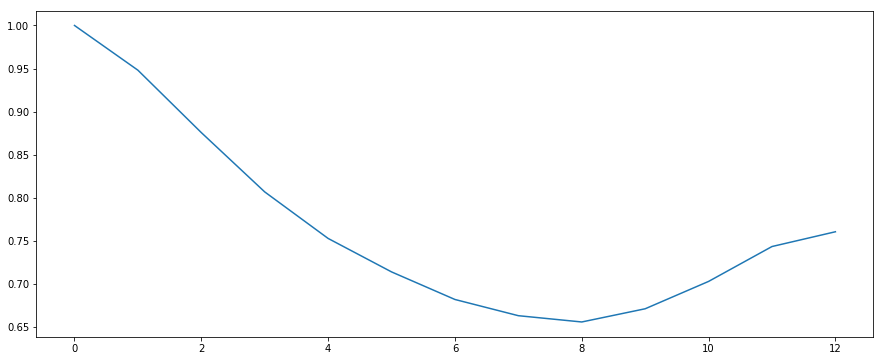

In [284]:
acf_result = acf(ts, nlags=12)
plt.plot(acf_result)
plt.show()

### Análise de Auto-correlação

In [285]:
values = DataFrame(ts.values)
df = concat([values.shift(1), values], axis=1)
df.columns = ['t-1', 't']
print df.corr()

          t-1         t
t-1  1.000000  0.960195
t    0.960195  1.000000


### Teste de Estacionariedade

- Explicar teste adfuller

In [286]:
def test_stationarity(timeseries):
    
    # determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd  = timeseries.rolling(window=12, center=False).std()

    # plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

    # perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print dfoutput

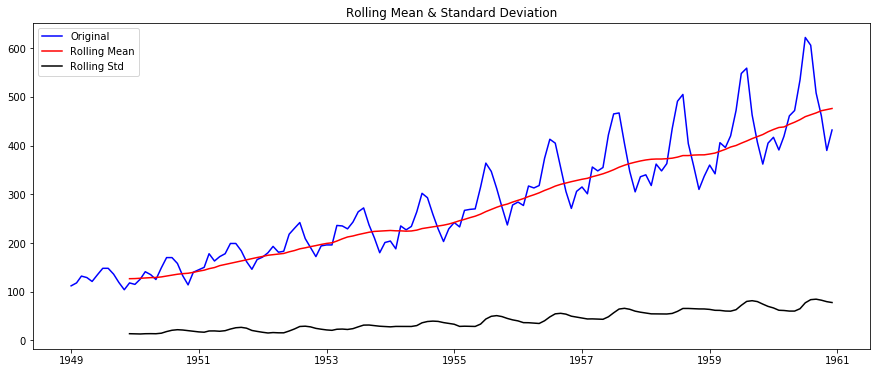

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [287]:
test_stationarity(ts)

### Estacionariedade por Decomposição

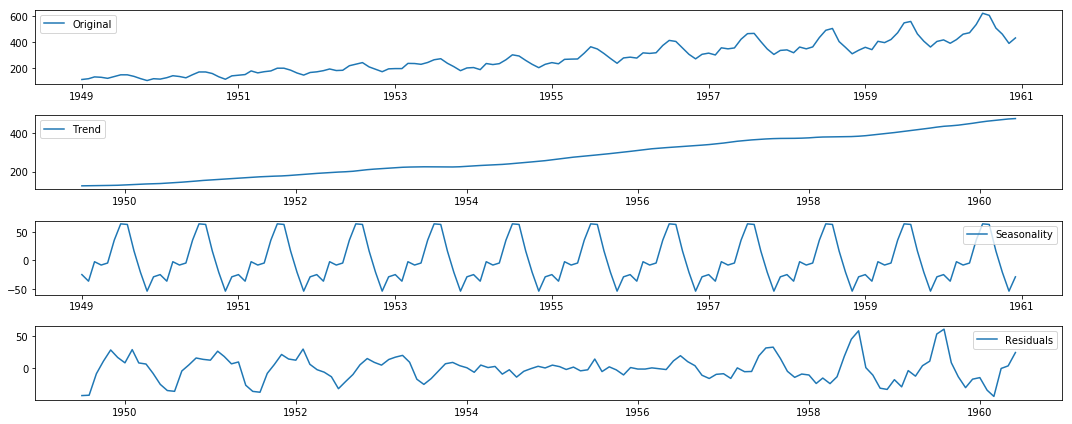

In [288]:
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# original serie
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')

# trend removie
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

# seasonality removie
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

# residuals
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

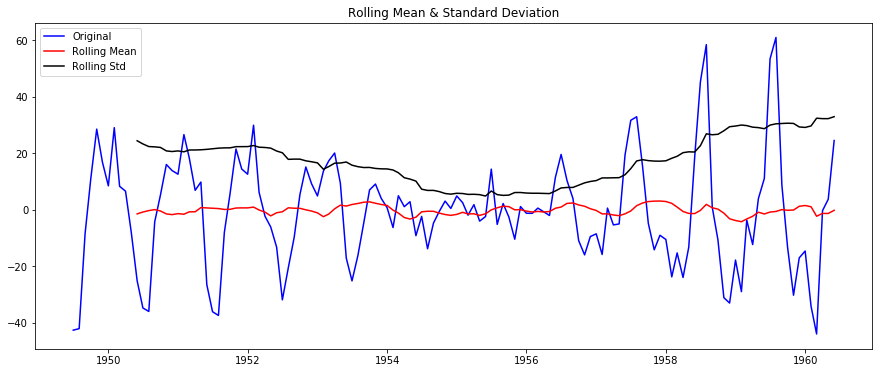

Results of Dickey-Fuller Test:
Test Statistic                  -5.298428
p-value                          0.000006
Lags Used                       13.000000
Number of Observations Used    118.000000
Critical Value (5%)             -2.886363
Critical Value (1%)             -3.487022
Critical Value (10%)            -2.580009
dtype: float64


In [289]:
residual
residual.dropna(inplace=True)
test_stationarity(residual)

### Estacionariedade por Diferenciação

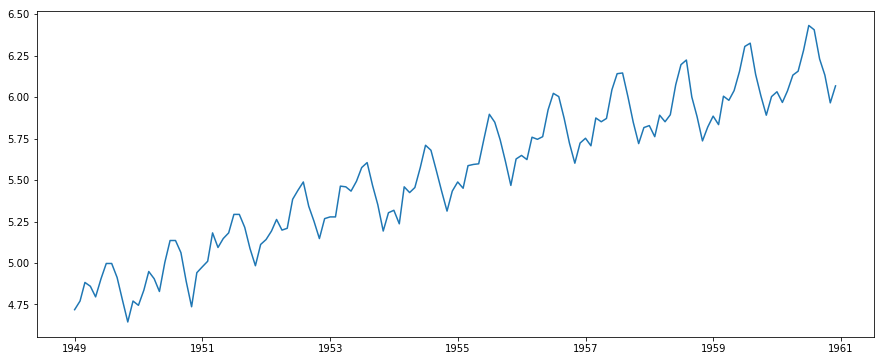

In [290]:
ts_log = np.log(ts)
plt.plot(ts_log)

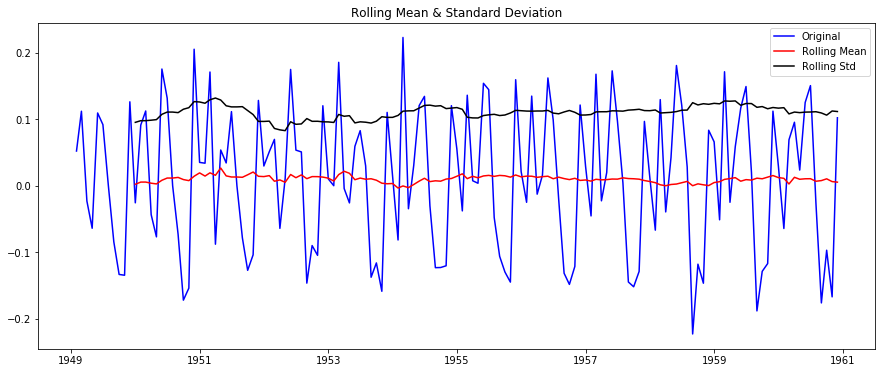

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
Lags Used                       14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [291]:
# difference
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

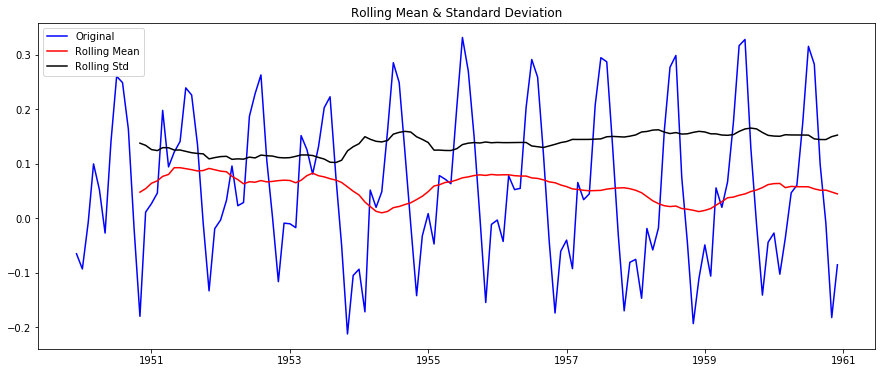

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
Lags Used                       13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [292]:
moving_avg = ts_log.rolling(window=12, center=False).mean()

# rolling mean
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### Data Split

In [293]:
values = DataFrame(ts_log_diff.values)
#values = DataFrame(ts_log.values)
df = concat([values.shift(1), values], axis=1)
df.columns = ['t-1', 't']

# split train / test
X = df.values
train, test = X[1:len(X)-12], X[len(X)-12:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

### Baseline

Test MSE: 0.016


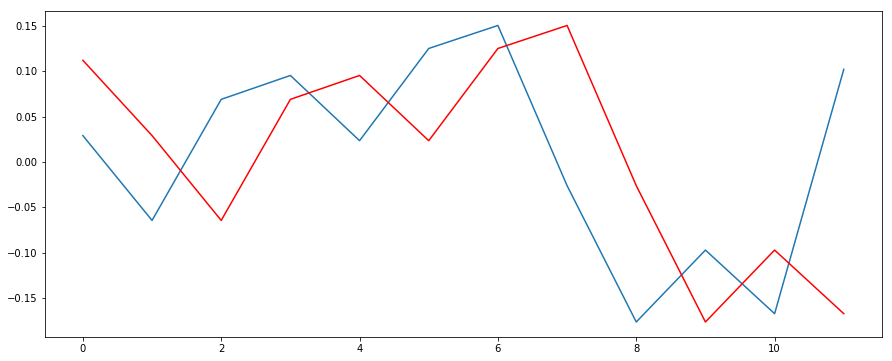

In [294]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = x
    predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

### Modelo Auto-Regressivo

Lag: 13
Coefficients: [ 0.02356897 -0.36029273 -0.22741737 -0.14969385 -0.24655402 -0.10494971
 -0.21797499 -0.15307868 -0.26603189 -0.11852424 -0.22463325 -0.10080862
  0.68785455  0.26934732]
predicted=0.044878, expected=0.029199
predicted=-0.043431, expected=-0.064379
predicted=0.132581, expected=0.069163
predicted=-0.005558, expected=0.095527
predicted=0.060574, expected=0.023581
predicted=0.115881, expected=0.125288
predicted=0.134686, expected=0.150673
predicted=0.015538, expected=-0.026060
predicted=-0.176789, expected=-0.176399
predicted=-0.137034, expected=-0.097083
predicted=-0.113738, expected=-0.167251
predicted=0.106322, expected=0.102279
Test MSE: 0.002


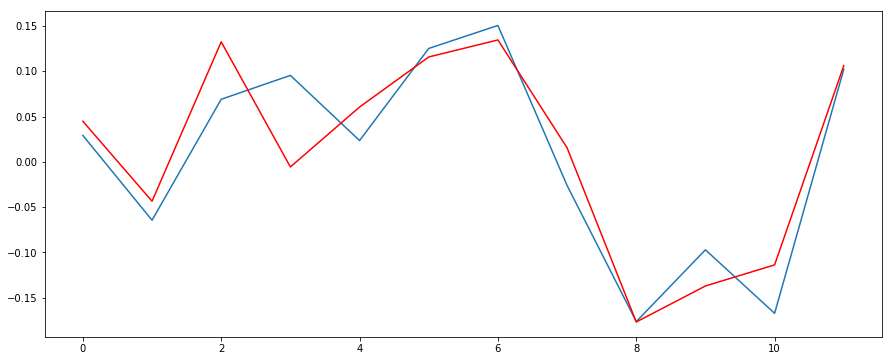

In [295]:
# split dataset
X = ts_log_diff.values
train, test = X[1:len(X)-12], X[len(X)-12:]

# train autoregression
model = AR(train)
model_fit = model.fit(disp=-1)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

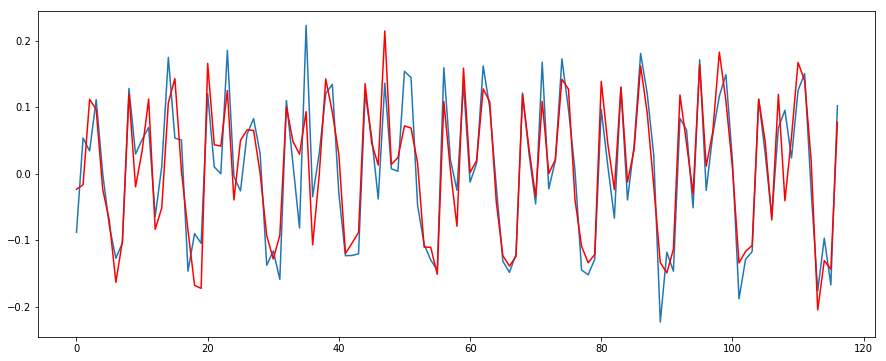

In [296]:
plt.plot(ts_log_diff.values[26:])
plt.plot(model_fit.fittedvalues, color='red')

### Escala Original

Text(0.5,1,u'RMSE: 0.2579')

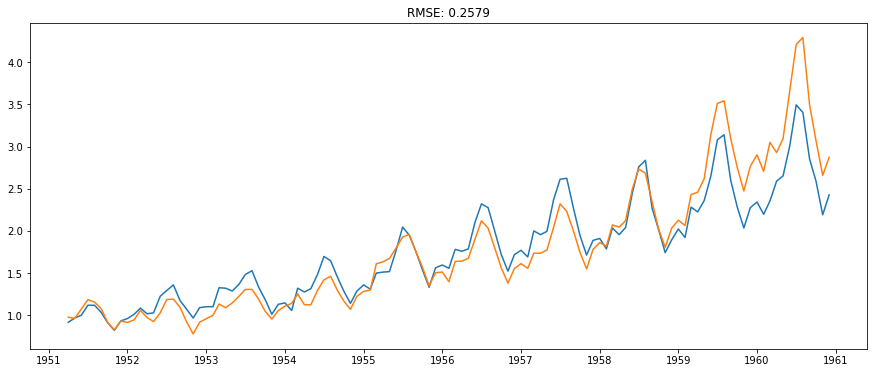

In [297]:
# original data.
orig_data = np.exp(ts_log_diff[26:].cumsum())
plt.plot(orig_data)

# predicted data.
pred_data = np.exp(Series(model_fit.fittedvalues, index=original.index).cumsum())
plt.plot(pred_data)

plt.title('RMSE: %.4f'% np.sqrt(sum((pred_data-orig_data)**2)/len(orig_data)))